Epoch 1/5 - Train Loss: 1.0618  Train Acc: 0.3358  Val Acc: 0.3233
Epoch 2/5 - Train Loss: 0.9635  Train Acc: 0.3917  Val Acc: 0.6700
Epoch 3/5 - Train Loss: 0.8755  Train Acc: 0.6500  Val Acc: 0.6700
Epoch 4/5 - Train Loss: 0.7932  Train Acc: 0.6958  Val Acc: 0.9700
Epoch 5/5 - Train Loss: 0.7117  Train Acc: 0.9750  Val Acc: 0.9933


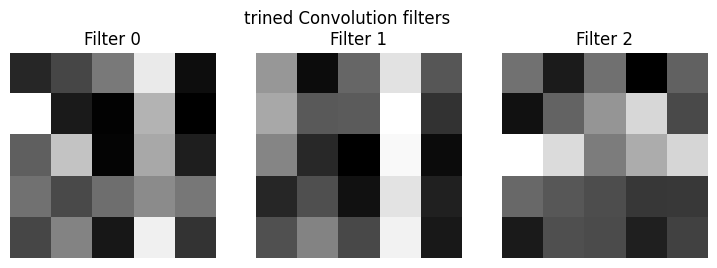

테스트 이미지 실제 클래스: 1


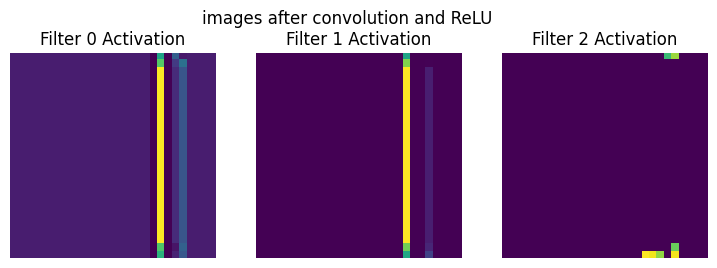

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. 토이 데이터셋 생성 (가로, 세로, 대각선 선 이미지)
# --------------------------------------------
class LineDataset(Dataset):
    def __init__(self, img_size=28, samples_per_class=500):
        self.img_size = img_size
        self.samples_per_class = samples_per_class
        images = []
        labels = []

        # 클래스 0: 가로선
        for _ in range(samples_per_class):
            image = np.zeros((img_size, img_size), dtype=np.float32)
            y_pos = np.random.randint(0, img_size)
            image[y_pos, :] = 1.0
            images.append(image)
            labels.append(0)

        # 클래스 1: 세로선
        for _ in range(samples_per_class):
            image = np.zeros((img_size, img_size), dtype=np.float32)
            x_pos = np.random.randint(0, img_size)
            image[:, x_pos] = 1.0
            images.append(image)
            labels.append(1)

        # 클래스 2: 대각선 (45°)
        for _ in range(samples_per_class):
            image = np.zeros((img_size, img_size), dtype=np.float32)
            start_y = np.random.randint(0, img_size)
            for x in range(img_size):
                y_pos = start_y + x
                if y_pos < img_size:
                    image[y_pos, x] = 1.0
            images.append(image)
            labels.append(2)

        images = np.array(images)  # (1500, 28, 28)
        labels = np.array(labels)  # (1500,)

        # 채널 차원 추가 -> (1500, 1, 28, 28)
        images = images.reshape(-1, 1, img_size, img_size)

        # 섞기
        indices = np.arange(len(labels))
        np.random.shuffle(indices)
        images = images[indices]
        labels = labels[indices]

        self.images = torch.tensor(images)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# --------------------------------------------
# 2. 데이터 분할 및 DataLoader 준비
# --------------------------------------------
dataset = LineDataset(img_size=28, samples_per_class=500)
total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# --------------------------------------------
# 3. 간단한 CNN 모델 정의 (PyTorch)
# --------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        # 합성곱 층: filters=3, kernel_size=3x3, activation은 ReLU
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=2)
        # 전역 max pooling -> (batch, 3, 1, 1)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        # 출력층: num_classes
        self.fc = nn.Linear(3, num_classes)

    def forward(self, x):
        x = self.conv(x)              # (batch, 3, 28, 28)
        x = torch.relu(x)             # ReLU 활성화
        x = self.global_pool(x)       # (batch, 3, 1, 1)
        x = x.view(x.size(0), -1)     # (batch, 3)
        x = self.fc(x)                # (batch, num_classes)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=3).to(device)

# --------------------------------------------
# 4. 학습 설정
# --------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# --------------------------------------------
# 5. 학습 루프
# --------------------------------------------
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += images.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train

    # 검증
    model.eval()
    val_corrects = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_val += images.size(0)

    val_acc = val_corrects / total_val

    print(f"Epoch {epoch}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  "
          f"Val Acc: {val_acc:.4f}")

# --------------------------------------------
# 6. 학습된 커널(필터) 시각화
# --------------------------------------------
# conv.weight.shape = (3, 1, 3, 3)
conv_weights = model.conv.weight.data.cpu().numpy()  # numpy 배열로 변환
# (out_channels, in_channels, kh, kw) -> (3, 1, 3, 3)
# 0~1 정규화
w_min, w_max = conv_weights.min(), conv_weights.max()
weights_norm = (conv_weights - w_min) / (w_max - w_min)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    kernel = weights_norm[i, 0, :, :]  # (3, 3)
    axes[i].imshow(kernel, cmap='gray')
    axes[i].set_title(f"Filter {i}")
    axes[i].axis('off')
plt.suptitle("trined Convolution filters")
plt.show()

# --------------------------------------------
# 7. 활성화 맵 시각화 (임의의 테스트 이미지)
# --------------------------------------------
# 테스트용 이미지 하나 선택
test_img, test_label = dataset[0]
print(f"테스트 이미지 실제 클래스: {test_label.item()}")

# 모델을 eval 모드로 설정
model.eval()
with torch.no_grad():
    # (1, 1, 28, 28) 형태로 배치 차원 추가
    input_img = test_img.unsqueeze(0).to(device)
    # conv 레이어 출력 얻기
    conv_out = model.conv(input_img)        # (1, 3, 28, 28)
    conv_out_relu = torch.relu(conv_out).cpu().numpy()[0]  # (3, 28, 28)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    activation_map = conv_out_relu[i]  # (28, 28)
    axes[i].imshow(activation_map, cmap='viridis')
    axes[i].set_title(f"Filter {i} Activation")
    axes[i].axis('off')
plt.suptitle("images after convolution and ReLU")
plt.show()
